**Imports**

In [26]:
import pandas as pd
import numpy as np
import torch
from huggingface_hub import login

from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel

from sklearn import metrics
from sklearn.metrics import precision_score, recall_score, roc_auc_score, multilabel_confusion_matrix, ConfusionMatrixDisplay

from itertools import chain

from scipy import stats

import math
import matplotlib as plt

try:
    import cPickle as pickle
except ImportError:  # Python 3.x
    import pickle

In [27]:
# Setting up the device for GPU usage

from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

In [28]:
pd.set_option('display.max_columns', None)

**Test data**

In [29]:
import io

class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else: return super().find_class(module, name)

In [96]:
#opening the model files
with open('9-CV-Category-history.p', 'rb') as fp:
    history = CPU_Unpickler(fp).load()

In [97]:
#train files depends on model
train = pd.read_csv('all-gendered.csv')
#train = pd.read_csv('all_CV_sample.csv')

In [106]:
with open('CV_category_perf.p', 'rb') as fp:
    og_performance = CPU_Unpickler(fp).load()
    #history = pickle.load(fp)

In [62]:
with open('all_syn_eda_perf.p', 'rb') as fp:
    syn_performance = CPU_Unpickler(fp).load()
    #history = pickle.load(fp)

In [63]:
with open('all_back_trans_perf.p', 'rb') as fp:
    trans_performance = CPU_Unpickler(fp).load()
    #history = pickle.load(fp)

In [64]:
with open('all_sample_perf.p', 'rb') as fp:
    sample_performance = CPU_Unpickler(fp).load()
    #history = pickle.load(fp)

**Evaluation**

Affective
Motivational
Cognitive
Cog_distortions
Behavioral
Physiological


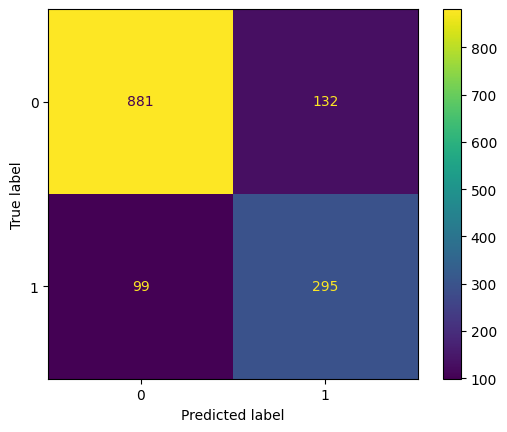

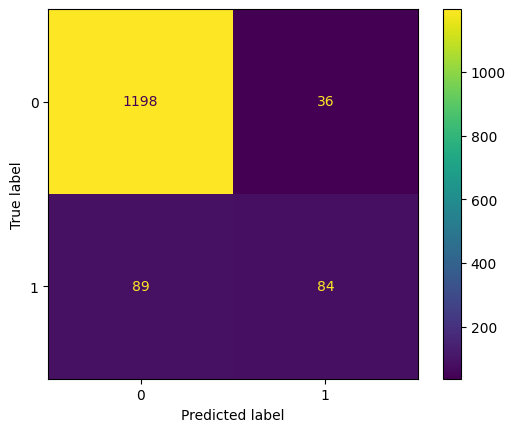

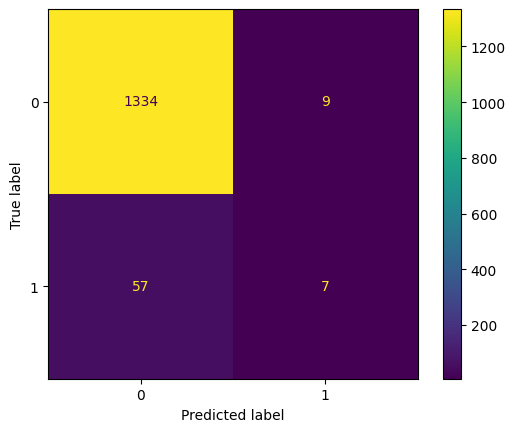

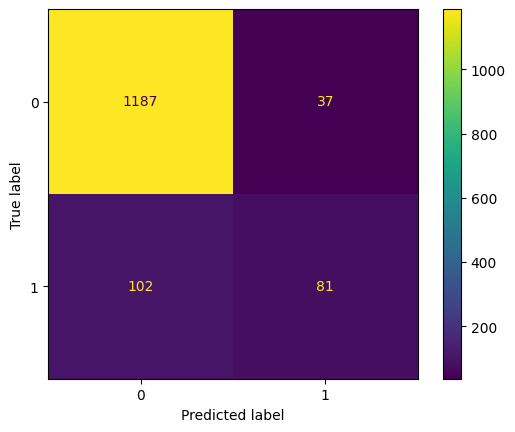

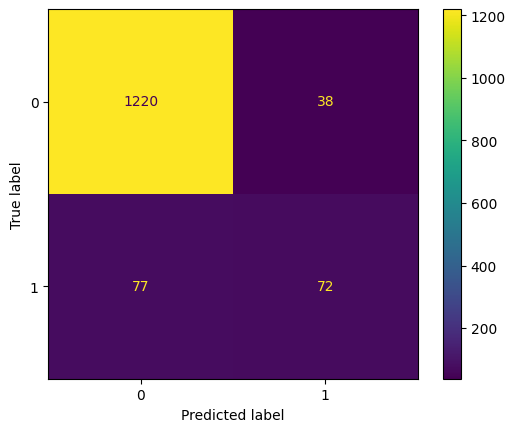

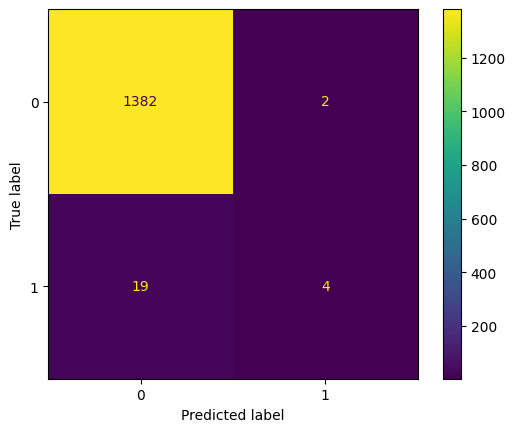

In [126]:
#confusion matrices
cm = multilabel_confusion_matrix(sample_performance['targets'], sample_performance['outputs'])
num = 26
for matrix in cm:
    print(train.columns[num])
    disp = ConfusionMatrixDisplay(confusion_matrix=matrix)
    disp.plot()
    num += 1

In [87]:
#weighted macro f1 score
f1_add = 0
P_all = []

for i in range(len(history['valid_f1_weighted'])):
    P_all.append(sum(trans_performance['P'][i]))
    f1_add += history['valid_f1_weighted'][i]*P_all[i]

f1 = f1_add/sum(P_all)
print('F1 Score: ', f1)

F1 Score:  0.6181315055980592


In [88]:
#weighted macro f1 score per gender
keys = [['m_f1_weighted', 'm_P'], ['f_f1_weighted', 'f_P']]

f1_scores = []

for key1, key2 in keys:
    f1_add = 0
    P_all = []
    for i in range(len(history['valid_f1_weighted'])):
        P_all.append(sum(trans_performance[key2][i]))
        f1_add += history['valid_f1_weighted'][i]*P_all[i]

    f1 = f1_add/sum(P_all)
    f1_scores.append(f1)
    print(key1, f1)

f1_scores[0]/f1_scores[1]

m_f1_weighted 0.6174353763130256
f_f1_weighted 0.6190020600538354


0.9974690169194694

In [89]:
#f1 scores, pred. equ. and equal opp. per category
keys2 = ['category_f1', 'm_category_f1', 'f_category_f1', 'category_equ_opp', 'category_fpr']

key_res = []

for key in keys2:
    print(key)
    cats = []
    for i in range(len(trans_performance['category_f1'][0])):
        cat_add = 0
        len_P = 0
        cat_res = [category[i] for category in trans_performance[key]]
        P_cat = [category[i] for category in trans_performance['P']]
        #print(cat_res)
        print('Category: ', train.columns[i+26])
        for j in range(len(cat_res)):
            cat_add += cat_res[j]* P_cat[j]
            len_P += P_cat[j]
        cat_weighted = cat_add/len_P
        cats.append(cat_weighted)

        print(key, cat_weighted)
    
    key_res.append(cats)

category_f1
Category:  Affective
category_f1 0.7284542258410686
Category:  Motivational
category_f1 0.530526142522544
Category:  Cognitive
category_f1 0.30228625541125537
Category:  Cog_distortions
category_f1 0.646090647693551
Category:  Behavioral
category_f1 0.5892772624974092
Category:  Physiological
category_f1 0.1831357048748353
m_category_f1
Category:  Affective
m_category_f1 0.6248036833737565
Category:  Motivational
m_category_f1 0.40754589015093223
Category:  Cognitive
m_category_f1 0.2309027777777778
Category:  Cog_distortions
m_category_f1 0.727964488458809
Category:  Behavioral
m_category_f1 0.47013087377283996
Category:  Physiological
m_category_f1 0.14855072463768115
f_category_f1
Category:  Affective
f_category_f1 0.4903498903498904
Category:  Motivational
f_category_f1 0.5979291251384276
Category:  Cognitive
f_category_f1 0.11830357142857142
Category:  Cog_distortions
f_category_f1 0.40379882289994656
Category:  Behavioral
f_category_f1 0.4332093023255814
Category:  Ph

In [91]:
#f1 score ratios per category
male = key_res[1]
fem = key_res[2]

for i in range(len(male)):
    f1_ratio = male[i]/fem[i]
    print(f1_ratio)

1.2741997003974574
0.6815956490772725
1.9517819706498953
1.8027900211070806
1.0852280208413205
0.7321428571428572


In [92]:
FP_diff_all = []
equal_opp_all = []
P_all = []

for i in range(len(trans_performance['category_f1'][0])):
        FP_cat_add = 0
        equ_odd_cat_add = 0
        len_P = 0
        FP_cat_res = [category[i] for category in trans_performance['category_fpr']]
        equ_opp_cat_res = [category[i] for category in trans_performance['category_equ_opp']]
        P_cat = [category[i] for category in trans_performance['P']]
        for j in range(len(FP_cat_res)):     
                FP_cat_add += FP_cat_res[j]* P_cat[j]
                equ_odd_cat_add += equ_opp_cat_res[j]*P_cat[j]
                len_P += P_cat[j]
        FP_cat = FP_cat_add/len_P
        equ_odd_cat = equ_odd_cat_add/len_P
        
        print('Category: ', train.columns[i+26])
        print('Pred equ.: ', FP_cat)
        print('Equal odds: ', equ_odd_cat)

        FP_diff_all.append(FP_cat)
        equal_opp_all.append(equ_odd_cat)
        P_all.append(len_P)

Category:  Affective
Pred equ.:  2.112184946566256
Equal odds:  0.8690940351665534
Category:  Motivational
Pred equ.:  3.7130270148759896
Equal odds:  0.7816087981859411
Category:  Cognitive
Pred equ.:  0.9705874713626764
Equal odds:  1.2479166666666666
Category:  Cog_distortions
Pred equ.:  1.9192829358735113
Equal odds:  1.359588389138951
Category:  Behavioral
Pred equ.:  0.6361905226408213
Equal odds:  1.4382257727652463
Category:  Physiological
Pred equ.:  0.9778742659890203
Equal odds:  1.5507246376811594


In [93]:
#weighted macro pred. equ. and equal opp.

len_P = 0
test_index = []
FP_category_add = 0
equ_opp_category_add = 0

for i in range(len(trans_performance['category_f1'][0])):
    FP_category_add += FP_diff_all[i]*P_all[i]
    equ_opp_category_add += equal_opp_all[i]*P_all[i]
    len_P += P_all[i]

FP_diffs = FP_category_add/len_P
equ_opps = equ_opp_category_add/len_P  
print('FPR Difference: ', FP_diffs)
print('Equal Opportunity: ', equ_opps)

FPR Difference:  2.03722030904948
Equal Opportunity:  1.066977677542809


In [117]:
#t test overall f1 score
male_perf = [x for x in sample_performance['m_f1_weighted'] if not math.isnan(x)]
female_perf = [x for x in sample_performance['f_f1_weighted'] if not math.isnan(x)]
#print(female_perf)
print(stats.ttest_ind(male_perf, female_perf))

TtestResult(statistic=1.2913202855144164, pvalue=0.21493759944458768, df=16.0)


In [118]:
#t test gender differences TP and FP per category
keys = [['Male_TP', 'Female_TP'], ['Male_FP', 'Female_FP']]

for key in keys:  
    print(key)
    male = key[0]
    female = key[1]
    for i in range(len(sample_performance[male][0])):
        #print(performance[male])
        male_perf = [category[i] for category in sample_performance[male] if not math.isnan(category[i])]
        female_perf = [category[i] for category in sample_performance[female] if not math.isnan(category[i])]
        #print(male_perf)
        print('Category: ', train.columns[i+26])
        #print(female_perf)
        print(stats.ttest_ind(male_perf, female_perf))

['Male_TP', 'Female_TP']
Category:  Affective
TtestResult(statistic=-1.427302723653648, pvalue=0.17271800394032202, df=16.0)
Category:  Motivational
TtestResult(statistic=-0.94543529449515, pvalue=0.3584966479050049, df=16.0)
Category:  Cognitive
TtestResult(statistic=-0.831241648738794, pvalue=0.4180699650657673, df=16.0)
Category:  Cog_distortions
TtestResult(statistic=-1.1058919459448662, pvalue=0.28512496805083615, df=16.0)
Category:  Behavioral
TtestResult(statistic=0.00255920644491713, pvalue=0.9979896881869292, df=16.0)
Category:  Physiological
TtestResult(statistic=0.11639344262295018, pvalue=0.9087891503490467, df=16.0)
['Male_FP', 'Female_FP']
Category:  Affective
TtestResult(statistic=0.11893194971384194, pvalue=0.9068097025323447, df=16.0)
Category:  Motivational
TtestResult(statistic=0.045230183456632246, pvalue=0.9644835415619822, df=16.0)
Category:  Cognitive
TtestResult(statistic=-1.2303462232222473, pvalue=0.23635039763979948, df=16.0)
Category:  Cog_distortions
TtestR

In [119]:
#t test pred. equ. and equal opp. original model and augmented models
keys = ['category_equ_opp', 'category_fpr']

for key in keys:
    print(key)  
    for i in range(len(og_performance[key][0])):
        #print(performance[male])
        og_cat_perf = [category[i] for category in og_performance[key] if not math.isnan(category[i])]
        new_cat_perf = [category[i] for category in sample_performance[key] if not math.isnan(category[i])]
        #print(male_perf)
        print('Category: ', train.columns[i+26])
        #print(female_perf)
        print(stats.ttest_ind(og_cat_perf, new_cat_perf))

category_equ_opp
Category:  Affective
TtestResult(statistic=-0.3377193245364823, pvalue=0.7399649577119425, df=16.0)
Category:  Motivational
TtestResult(statistic=0.026627766159544968, pvalue=0.9790859175422424, df=16.0)
Category:  Cognitive
TtestResult(statistic=-0.7513983270989288, pvalue=0.46332280173536167, df=16.0)
Category:  Cog_distortions
TtestResult(statistic=-0.16473671889049385, pvalue=0.8712144950494216, df=16.0)
Category:  Behavioral
TtestResult(statistic=-0.7798142910203847, pvalue=0.44688295530697997, df=16.0)
Category:  Physiological
TtestResult(statistic=0.45523576490032375, pvalue=0.6550562538858751, df=16.0)
category_fpr
Category:  Affective
TtestResult(statistic=1.3421459729717493, pvalue=0.19828478375078934, df=16.0)
Category:  Motivational
TtestResult(statistic=0.6678684551195743, pvalue=0.5137368217721048, df=16.0)
Category:  Cognitive
TtestResult(statistic=1.0884121195302878, pvalue=0.2925367463876182, df=16.0)
Category:  Cog_distortions
TtestResult(statistic=1.